# Enhanced XOR-Style Customer Behavior Dataset v_3

In [1]:
# Comparing model performance with different hidden layer sizes on non-linearly separable data

import torch  # Import PyTorch for neural network operations
import torch.nn as nn  # Import neural network modules from PyTorch
import matplotlib.pyplot as plt  # Import matplotlib for plotting and visualization
import numpy as np  # Import numpy for numerical operations
from torch.utils.data import Dataset, DataLoader  # Import data handling utilities
from matplotlib.colors import ListedColormap  # Import color mapping for decision boundary visualization

torch.manual_seed(42)  # Ensure reproducible results across experiments

In [2]:
# =============================================================================
# XOR-Style Customer Dataset (Non-Linearly Separable Problem)
# =============================================================================

class XORStyleCustomerDataset(Dataset):  # Custom dataset class for XOR-style customer behavior patterns
    """Create XOR-style customer behavior dataset where simple linear boundaries fail"""
    
    def __init__(self, num_samples=1000):  # Constructor to initialize dataset with specified number of samples
        self.len = num_samples  # Store the total number of samples in the dataset
        
        # XOR-style pattern: opposite corners have same label
        # Region 1: Low time, Low engagement -> No Purchase (0,0) -> 0
        # Region 2: Low time, High engagement -> Purchase (0,1) -> 1  
        # Region 3: High time, Low engagement -> Purchase (1,0) -> 1
        # Region 4: High time, High engagement -> No Purchase (1,1) -> 0
        
        self.browsing_time = torch.zeros((num_samples, 2))  # Initialize tensor for 2D input features (time, engagement)
        self.purchased = torch.zeros((num_samples, 1))  # Initialize tensor for binary labels (purchase/no purchase)
        
        samples_per_region = num_samples // 4  # Calculate how many samples per XOR region (divide by 4 regions)
        
        for i in range(samples_per_region):  # Loop through samples for each region
            # Region 1: Low time, Low engagement -> No Purchase (XOR: 0⊕0=0)
            self.browsing_time[i, :] = torch.tensor([0.0, 0.0]) + 0.3 * torch.randn(2)  # Set base point [0,0] plus Gaussian noise
            self.purchased[i, 0] = 0.0  # Set label to 0 (no purchase)
            
            # Region 2: Low time, High engagement -> Purchase (XOR: 0⊕1=1)
            self.browsing_time[i + samples_per_region, :] = torch.tensor([0.0, 1.0]) + 0.3 * torch.randn(2)  # Set base point [0,1] plus noise
            self.purchased[i + samples_per_region, 0] = 1.0  # Set label to 1 (purchase)
            
            # Region 3: High time, Low engagement -> Purchase (XOR: 1⊕0=1)
            self.browsing_time[i + 2*samples_per_region, :] = torch.tensor([1.0, 0.0]) + 0.3 * torch.randn(2)  # Set base point [1,0] plus noise
            self.purchased[i + 2*samples_per_region, 0] = 1.0  # Set label to 1 (purchase)
            
            # Region 4: High time, High engagement -> No Purchase (XOR: 1⊕1=0)
            self.browsing_time[i + 3*samples_per_region, :] = torch.tensor([1.0, 1.0]) + 0.3 * torch.randn(2)  # Set base point [1,1] plus noise
            self.purchased[i + 3*samples_per_region, 0] = 0.0  # Set label to 0 (no purchase)
    
    def __getitem__(self, index):  # Required method to get a single sample by index
        return self.browsing_time[index], self.purchased[index]  # Return feature-label pair for given index
    
    def __len__(self):  # Required method to return dataset size
        return self.len  # Return total number of samples


In [3]:
# =============================================================================
# Neural Network Model (Configurable Hidden Layer Size)
# =============================================================================

class XORCustomerNet(nn.Module):  # Neural network class for XOR-style customer purchase prediction
    """Neural network with configurable hidden layer size for XOR-style problems"""
    
    def __init__(self, input_size, hidden_size, output_size):  # Network architecture definition with flexible hidden size
        super(XORCustomerNet, self).__init__()  # Initialize parent class
        
        self.hidden = nn.Linear(input_size, hidden_size)  # Hidden layer transformation (input to hidden)
        self.output = nn.Linear(hidden_size, output_size)  # Output layer transformation (hidden to output)
    
    def forward(self, x):  # Forward pass through network
        hidden_output = torch.sigmoid(self.hidden(x))  # Apply sigmoid activation to hidden layer (like XOR examples)
        purchase_probability = torch.sigmoid(self.output(hidden_output))  # Apply sigmoid to output for probability
        return purchase_probability  # Return purchase probability


In [4]:
# =============================================================================
# Training Function with Performance Tracking
# =============================================================================

def train_xor_model(model, train_loader, dataset, criterion, optimizer, num_epochs):  # Training with comprehensive performance tracking
    """Train XOR model and track both loss and accuracy performance"""
    
    train_losses = []  # Track training loss over epochs
    train_accuracies = []  # Track training accuracy over epochs
    
    for epoch in range(num_epochs):  # Training loop over epochs
        model.train()  # Set model to training mode
        epoch_loss = 0.0  # Accumulate training loss for current epoch
        
        # Training phase
        for batch_x, batch_y in train_loader:  # Process training batches
            optimizer.zero_grad()  # Clear gradients from previous iteration
            predictions = model(batch_x)  # Forward pass to get predictions
            loss = criterion(predictions, batch_y)  # Calculate loss between predictions and true labels
            loss.backward()  # Backward pass to compute gradients
            optimizer.step()  # Update model parameters using gradients
            epoch_loss += loss.item()  # Accumulate loss for this batch
        
        # Calculate accuracy on full dataset
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient computation for accuracy calculation
            all_predictions = model(dataset.browsing_time)  # Get predictions on full dataset
            predicted_classes = (all_predictions > 0.5).float()  # Convert probabilities to binary predictions
            accuracy = (predicted_classes == dataset.purchased).float().mean().item()  # Calculate accuracy percentage
        
        train_losses.append(epoch_loss / len(train_loader))  # Store average training loss per batch
        train_accuracies.append(accuracy)  # Store training accuracy for this epoch
    
    return train_losses, train_accuracies  # Return training metrics


In [5]:
# =============================================================================
# Decision Boundary Visualization Function
# =============================================================================

def plot_decision_regions_xor(model, dataset, title):  # Function to visualize XOR decision boundaries
    """Plot decision regions for XOR-style customer purchase prediction"""
    
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])  # Define light colors for decision regions (red/green)
    cmap_bold = ListedColormap(['#FF0000', '#00FF00'])   # Define bold colors for data points (red/green)
    
    X = dataset.browsing_time.numpy()  # Convert features to numpy array for plotting
    y = dataset.purchased.numpy()  # Convert labels to numpy array for plotting
    
    h = 0.02  # Set step size for meshgrid (smaller = more detailed decision boundary)
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5  # Calculate x-axis bounds with padding
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5  # Calculate y-axis bounds with padding
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))  # Create coordinate grid for decision boundary
    
    XX = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)  # Convert grid to tensor for model input
    
    with torch.no_grad():  # Disable gradients for inference
        yhat = (model(XX)[:, 0] > 0.5).numpy().reshape(xx.shape)  # Get model predictions on grid and reshape
    
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light, alpha=0.8)  # Plot decision regions as colored mesh
    
    # Plot data points with different colors for each class
    plt.plot(X[y[:, 0] == 0, 0], X[y[:, 0] == 0, 1], 'ro', markersize=6, label='No Purchase', alpha=0.7)  # Plot class 0 points in red
    plt.plot(X[y[:, 0] == 1, 0], X[y[:, 0] == 1, 1], 'go', markersize=6, label='Purchase', alpha=0.7)  # Plot class 1 points in green
    
    plt.xlabel('Browsing Time (normalized)')  # Set x-axis label
    plt.ylabel('Engagement Level (normalized)')  # Set y-axis label
    plt.title(title)  # Set plot title
    plt.legend()  # Show legend for data points
    plt.grid(True, alpha=0.3)  # Add grid with transparency


In [6]:
# =============================================================================
# Experiment: Compare Different Hidden Layer Sizes on XOR Problem
# =============================================================================

print("=== XOR-Style Neural Network: Testing Different Hidden Layer Sizes ===")

# Create XOR-style dataset
xor_dataset = XORStyleCustomerDataset(num_samples=400)  # Create dataset with 400 samples for XOR pattern
train_loader = DataLoader(dataset=xor_dataset, batch_size=10, shuffle=True)  # Create data loader with small batch size

# Different hidden layer sizes to test (following transcript: 1, 2, 3+ neurons)
hidden_sizes = [1, 2, 3, 4]  # Range from insufficient to sufficient neurons for XOR

# Model hyperparameters (kept constant except hidden size)
input_size = 2  # Two input features (browsing time, engagement)
output_size = 1  # Single output (purchase probability)
num_epochs = 500  # Training epochs (more needed for XOR complexity)
learning_rate = 0.1  # Learning rate for optimizer
batch_size = 10  # Small batch size for XOR learning

results = {}  # Store results for each hidden layer size

print(f"Dataset: XOR-style customer behavior with {len(xor_dataset)} samples")
print(f"Model architecture: {input_size} -> [VARIABLE] -> {output_size}")
print(f"Training epochs: {num_epochs}")

for hidden_size in hidden_sizes:  # Test each hidden layer size
    print(f"\n--- Training with {hidden_size} hidden neuron(s) ---")
    
    # Create fresh model for each experiment
    model = XORCustomerNet(input_size, hidden_size, output_size)  # Initialize new model with specified hidden size
    criterion = nn.BCELoss()  # Binary cross-entropy loss for binary classification
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  # SGD optimizer (as used in XOR examples)
    
    # Train the model
    train_losses, train_accuracies = train_xor_model(  # Train and track performance
        model, train_loader, xor_dataset, criterion, optimizer, num_epochs
    )
    
    # Store results
    final_accuracy = train_accuracies[-1]  # Get final training accuracy
    results[hidden_size] = {  # Store experiment results
        'model': model,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'final_accuracy': final_accuracy,
        'hidden_size': hidden_size
    }
    
    print(f"Final accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")

=== XOR-Style Neural Network: Testing Different Hidden Layer Sizes ===
Dataset: XOR-style customer behavior with 400 samples
Model architecture: 2 -> [VARIABLE] -> 1
Training epochs: 500

--- Training with 1 hidden neuron(s) ---
Final accuracy: 0.6850 (68.50%)

--- Training with 2 hidden neuron(s) ---
Final accuracy: 0.8875 (88.75%)

--- Training with 3 hidden neuron(s) ---
Final accuracy: 0.8825 (88.25%)

--- Training with 4 hidden neuron(s) ---
Final accuracy: 0.9075 (90.75%)


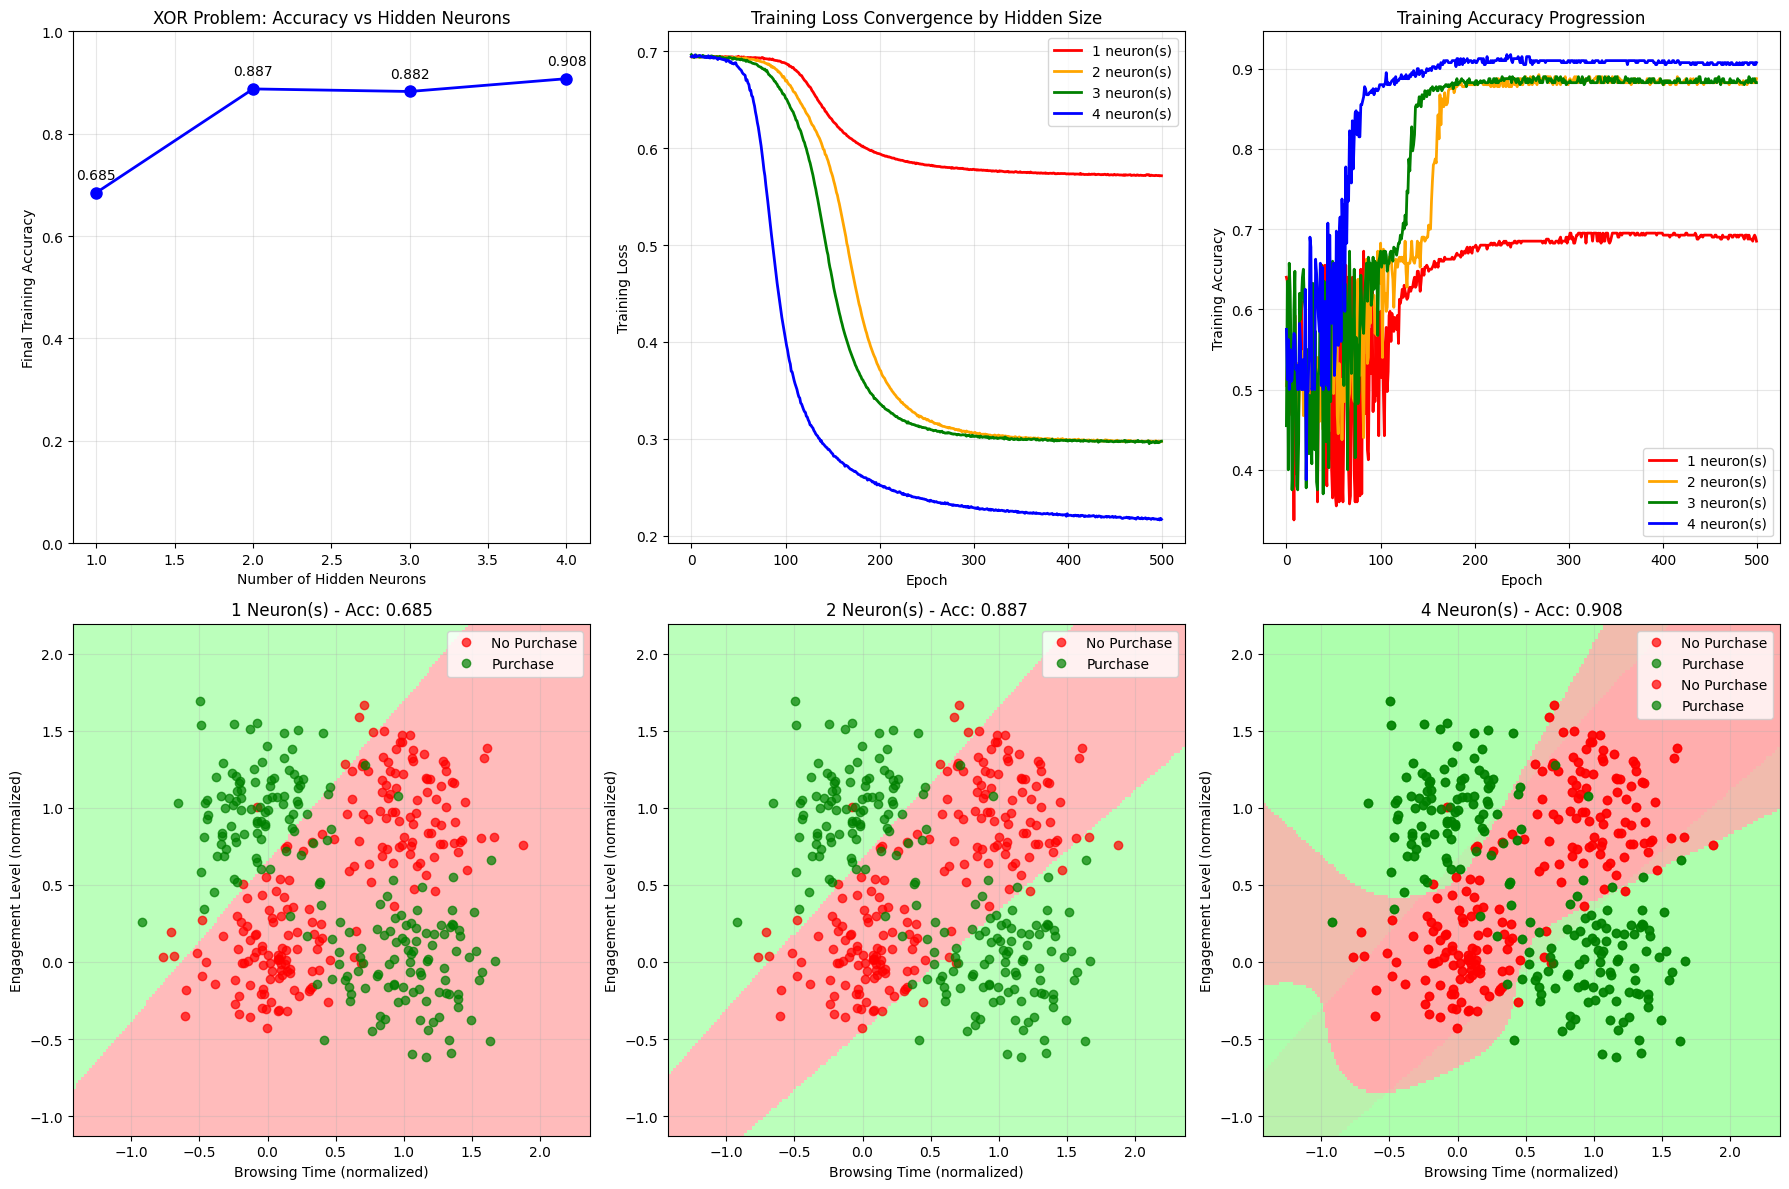

In [7]:
# =============================================================================
# Analyze and Visualize XOR Results
# =============================================================================

def plot_xor_analysis(results, xor_dataset):  # Comprehensive XOR analysis visualization
    """Plot comprehensive analysis of hidden layer size impact on XOR problem"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Create 2x3 subplot grid for comprehensive analysis
    
    # Plot 1: Training Accuracy Comparison
    ax1 = axes[0, 0]  # Top-left subplot
    hidden_sizes = list(results.keys())  # Get hidden layer sizes tested
    final_accuracies = [results[size]['final_accuracy'] for size in hidden_sizes]  # Get final accuracies
    
    ax1.plot(hidden_sizes, final_accuracies, 'bo-', linewidth=2, markersize=8)  # Line plot with markers
    ax1.set_xlabel('Number of Hidden Neurons')  # X-axis label
    ax1.set_ylabel('Final Training Accuracy')  # Y-axis label
    ax1.set_title('XOR Problem: Accuracy vs Hidden Neurons')  # Plot title
    ax1.grid(True, alpha=0.3)  # Add grid
    ax1.set_ylim(0, 1)  # Set y-axis limits from 0 to 1
    
    # Add accuracy values as text
    for size, acc in zip(hidden_sizes, final_accuracies):  # Add text labels for each point
        ax1.annotate(f'{acc:.3f}', (size, acc), textcoords="offset points", 
                    xytext=(0,10), ha='center')  # Position text above points
    
    # Plot 2: Training Loss Convergence
    ax2 = axes[0, 1]  # Top-right subplot
    colors = ['red', 'orange', 'green', 'blue']  # Colors for different neuron counts
    
    for i, size in enumerate(hidden_sizes):  # Plot training loss for each hidden size
        ax2.plot(results[size]['train_losses'], color=colors[i], 
                label=f'{size} neuron(s)', linewidth=2)  # Loss curve for each configuration
    
    ax2.set_xlabel('Epoch')  # X-axis label
    ax2.set_ylabel('Training Loss')  # Y-axis label
    ax2.set_title('Training Loss Convergence by Hidden Size')  # Plot title
    ax2.legend()  # Show legend
    ax2.grid(True, alpha=0.3)  # Add grid
    
    # Plot 3: Training Accuracy Progression
    ax3 = axes[0, 2]  # Top-right subplot
    
    for i, size in enumerate(hidden_sizes):  # Plot accuracy progression for each hidden size
        ax3.plot(results[size]['train_accuracies'], color=colors[i], 
                label=f'{size} neuron(s)', linewidth=2)  # Accuracy curve for each configuration
    
    ax3.set_xlabel('Epoch')  # X-axis label
    ax3.set_ylabel('Training Accuracy')  # Y-axis label
    ax3.set_title('Training Accuracy Progression')  # Plot title
    ax3.legend()  # Show legend
    ax3.grid(True, alpha=0.3)  # Add grid
    
    # Plot 4-7: Decision Boundaries for Each Model
    for i, size in enumerate(hidden_sizes):  # Create decision boundary plot for each model
        ax = axes[1, i] if i < 3 else axes[1, 2]  # Select appropriate subplot position
        plt.sca(ax)  # Set current axes
        plot_decision_regions_xor(results[size]['model'], xor_dataset, 
                                f'{size} Neuron(s) - Acc: {results[size]["final_accuracy"]:.3f}')  # Plot decision regions
    
    # Hide the unused subplot
    if len(hidden_sizes) < 4:  # If we have fewer than 4 configurations
        axes[1, 3].set_visible(False)  # Hide the unused subplot
    
    plt.tight_layout()  # Adjust subplot spacing
    plt.show()  # Display plots

# Generate comprehensive XOR analysis
plot_xor_analysis(results, xor_dataset)  # Create comprehensive analysis visualization


In [8]:
# =============================================================================
# Statistical Analysis of XOR Results
# =============================================================================

print(f"\n=== Statistical Analysis of Hidden Layer Size Impact on XOR Problem ===")

# Analyze performance by hidden layer size
hidden_sizes_sorted = sorted(results.keys())  # Sort hidden layer sizes
accuracies = [results[size]['final_accuracy'] for size in hidden_sizes_sorted]  # Get corresponding accuracies

print(f"Hidden Layer Size vs Final Accuracy:")
for size, acc in zip(hidden_sizes_sorted, accuracies):  # Print size-accuracy pairs
    print(f"  {size} neuron(s): {acc:.4f} ({acc*100:.2f}%)")

# Calculate improvement metrics
baseline_acc = accuracies[0]  # Single neuron accuracy (baseline)
max_acc = max(accuracies)  # Best accuracy achieved
improvement = max_acc - baseline_acc  # Total improvement from baseline

print(f"\nKey Findings:")
print(f"• Baseline accuracy (1 neuron): {baseline_acc:.4f}")
print(f"• Maximum accuracy achieved: {max_acc:.4f}")
print(f"• Total improvement: {improvement:.4f} ({improvement*100:.2f} percentage points)")

# Find minimum neurons needed for good performance
good_performance_threshold = 0.9  # Define threshold for acceptable performance
min_neurons_needed = None  # Initialize minimum neurons variable

for size, acc in zip(hidden_sizes_sorted, accuracies):  # Find minimum neurons for good performance
    if acc >= good_performance_threshold:  # Check if accuracy meets threshold
        min_neurons_needed = size  # Record the neuron count
        break

if min_neurons_needed:  # If good performance threshold was reached
    print(f"• Minimum neurons for >90% accuracy: {min_neurons_needed}")
else:  # If threshold was never reached
    print(f"• No configuration achieved >90% accuracy (may need more neurons)")



=== Statistical Analysis of Hidden Layer Size Impact on XOR Problem ===
Hidden Layer Size vs Final Accuracy:
  1 neuron(s): 0.6850 (68.50%)
  2 neuron(s): 0.8875 (88.75%)
  3 neuron(s): 0.8825 (88.25%)
  4 neuron(s): 0.9075 (90.75%)

Key Findings:
• Baseline accuracy (1 neuron): 0.6850
• Maximum accuracy achieved: 0.9075
• Total improvement: 0.2225 (22.25 percentage points)
• Minimum neurons for >90% accuracy: 4


In [9]:
# =============================================================================
# XOR Problem Explanation and Insights
# =============================================================================

print(f"\n=== XOR Problem Explanation and Why Multiple Neurons Are Essential ===")

print(f"\nXOR Truth Table for Customer Behavior:")
print(f"• Low Time + Low Engagement → No Purchase (0 ⊕ 0 = 0)")
print(f"• Low Time + High Engagement → Purchase (0 ⊕ 1 = 1)")
print(f"• High Time + Low Engagement → Purchase (1 ⊕ 0 = 1)")
print(f"• High Time + High Engagement → No Purchase (1 ⊕ 1 = 0)")

print(f"\nWhy Single Neurons Fail:")
print(f"• Single neuron can only create LINEAR decision boundaries")
print(f"• XOR requires NON-LINEAR decision boundary")
print(f"• No single straight line can separate XOR classes correctly")

print(f"\nWhy Multiple Neurons Succeed:")
print(f"• Multiple neurons can combine to create complex boundaries")
print(f"• Each neuron learns a different linear separator")
print(f"• Final layer combines these separators non-linearly")
print(f"• Result: Complex decision boundary that solves XOR")

print(f"\nOptimal Architecture:")
if min_neurons_needed:
    print(f"• Minimum effective neurons: {min_neurons_needed}")
    print(f"• More neurons provide better approximation")
    print(f"• Too many neurons may overfit on small datasets")
else:
    print(f"• Need more than {max(hidden_sizes_sorted)} neurons for this XOR variant")
    print(f"• Consider adding more neurons or layers")

print(f"\nKey Insight: The transition from linear to non-linear separability")
print(f"requires multiple neurons with non-linear activation functions!")


=== XOR Problem Explanation and Why Multiple Neurons Are Essential ===

XOR Truth Table for Customer Behavior:
• Low Time + Low Engagement → No Purchase (0 ⊕ 0 = 0)
• Low Time + High Engagement → Purchase (0 ⊕ 1 = 1)
• High Time + Low Engagement → Purchase (1 ⊕ 0 = 1)
• High Time + High Engagement → No Purchase (1 ⊕ 1 = 0)

Why Single Neurons Fail:
• Single neuron can only create LINEAR decision boundaries
• XOR requires NON-LINEAR decision boundary
• No single straight line can separate XOR classes correctly

Why Multiple Neurons Succeed:
• Multiple neurons can combine to create complex boundaries
• Each neuron learns a different linear separator
• Final layer combines these separators non-linearly
• Result: Complex decision boundary that solves XOR

Optimal Architecture:
• Minimum effective neurons: 4
• More neurons provide better approximation
• Too many neurons may overfit on small datasets

Key Insight: The transition from linear to non-linear separability
requires multiple neuro